In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random

import clustering_functions as cf

In [2]:
import os
os.chdir('.')

In [3]:
execfile('pre_processing.py')

## Autoencoder (AE) + k-means

In [4]:
filepath_ae = 'plots/ae/'
if not os.path.exists(filepath_ae):
    os.makedirs(filepath_ae)

**Define and Train Autoencoder**

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 286)]             0         
                                                                 
 encoder_dense_1 (Dense)     (None, 256)               73472     
                                                                 
 encoder_dense_2 (Dense)     (None, 32)                8224      
                                                                 
 latent_space (Dense)        (None, 10)                330       
                                                                 
 decoder_dense_1 (Dense)     (None, 32)                352       
                                                                 
 decoder_dense_2 (Dense)     (None, 256)               8448      
                                                                 
 reconstruction (Dense)      (None, 286)               

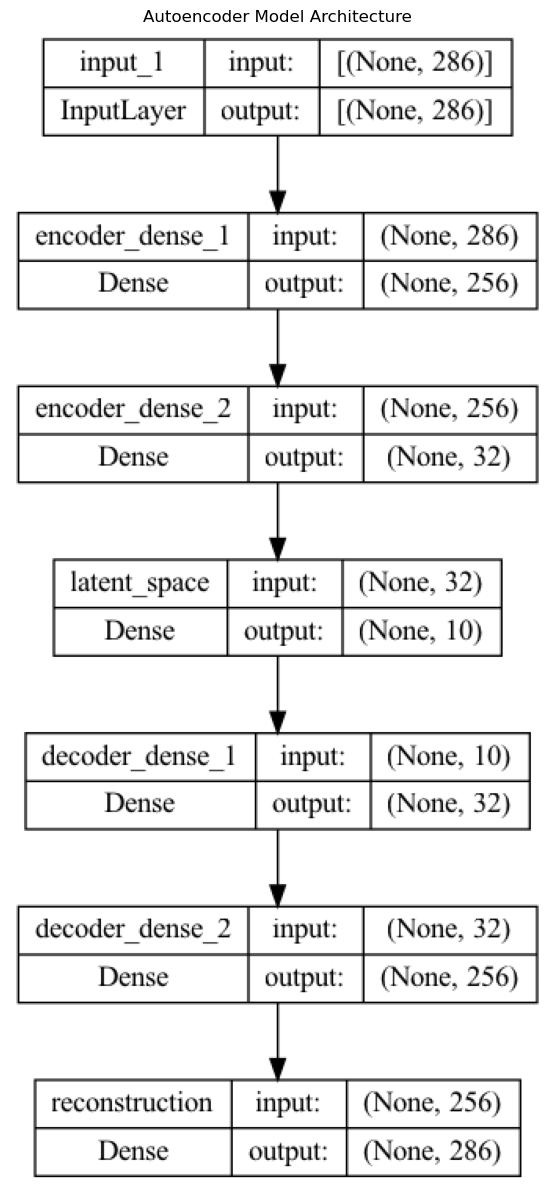

Epoch 1/50
314/314 [==============================] - 1s 2ms/step - loss: 0.1587 - val_loss: 0.0531
Epoch 2/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0467 - val_loss: 0.0446
Epoch 3/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0380 - val_loss: 0.0341
Epoch 4/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0326 - val_loss: 0.0320
Epoch 5/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0312 - val_loss: 0.0305
Epoch 6/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 0.0304
Epoch 7/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0298 - val_loss: 0.0293
Epoch 8/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0299
Epoch 9/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0287
Epoch 10/50
314/314 [==============================] - 1s 2ms/step - loss: 0.0285 - val_loss: 0.0286

In [5]:
# Prepare data for AE
nt, ny, nx = z500.shape
input_dim = ny * nx
z500_reshaped_ae = z500_reshaped.copy() # Use the reshaped data from pre_processing

# Split data for training and validation
X_train, X_val = train_test_split(z500_reshaped_ae, test_size=0.2, random_state=42)

# Define AE parameters
latent_dim = 10  # Latent dimension, similar to number of components in PCA/CCA
epochs = 50
batch_size = 32

# Build the Autoencoder model
input_layer = keras.Input(shape=(input_dim,))
# Encoder
encoded = layers.Dense(256, activation='relu', name='encoder_dense_1')(input_layer)
encoded = layers.Dense(32, activation='relu', name='encoder_dense_2')(encoded)
encoded = layers.Dense(latent_dim, activation='relu', name='latent_space')(encoded)
# Decoder
decoded = layers.Dense(32, activation='relu', name='decoder_dense_1')(encoded)
decoded = layers.Dense(256, activation='relu', name='decoder_dense_2')(decoded)
decoded = layers.Dense(input_dim, activation='linear', name='reconstruction')(decoded) # Linear activation for reconstruction

# Autoencoder model
autoencoder = keras.Model(input_layer, decoded, name='autoencoder')
# Encoder model
encoder = keras.Model(input_layer, encoded, name='encoder')

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print model summary
autoencoder.summary()

# Generate model diagram
model_diagram_path = filepath_ae + 'autoencoder_diagram.png'
tf.keras.utils.plot_model(autoencoder, to_file=model_diagram_path, show_shapes=True, show_layer_names=True)

# Display the diagram
img = plt.imread(model_diagram_path)
plt.figure(figsize=(10, 15)) # Adjust figure size as needed
plt.imshow(img)
plt.axis('off') # Hide axes
plt.title('Autoencoder Model Architecture')
plt.show()


# Train the model
history = autoencoder.fit(X_train, X_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_val, X_val),
                        verbose=1)

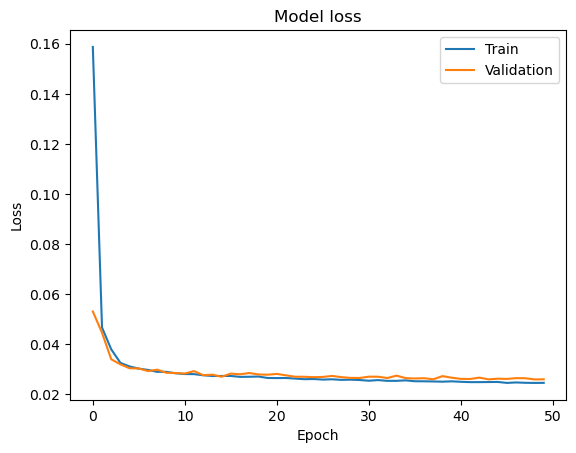

In [6]:
# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig(filepath_ae + 'training_loss.png')
plt.show()

**Get Latent Representation and Cluster**

In [7]:
# Get latent space representation
z500_latent = encoder.predict(z500_reshaped_ae)

# Perform k-means clustering on the latent space
k = 5
ae_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(z500_latent)

# Get cluster centroids in the latent space
latent_centroids = ae_clusters.cluster_centers_

# Decode centroids back to original space
# Need to build the decoder part separately if not done already
decoder_input = keras.Input(shape=(latent_dim,))
deco = autoencoder.layers[-3](decoder_input)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
decoder = keras.Model(decoder_input, deco)

centroids_reconstructed = decoder.predict(latent_centroids)
centroids_ae = centroids_reconstructed.reshape(k, ny, nx, order='F')

# Create xarray DataArray for centroids
centroids_ae_xr = xr.DataArray(centroids_ae, coords=z500[0:k, :, :].coords,
                               dims=z500[0:k, :, :].dims, attrs=z500[0:k, :, :].attrs)

1/1 [==============================] - 0s 36ms/step


**Calculate Silhouette Score for Different k**

Silhouette Score for k=4: 0.15069851279258728
Silhouette Score for k=5: 0.13715267181396484
Silhouette Score for k=6: 0.12190014868974686
Silhouette Score for k=7: 0.12116430699825287
Silhouette Score for k=8: 0.12367478013038635
Silhouette Score for k=9: 0.12096961587667465
Silhouette Score for k=10: 0.11314502358436584


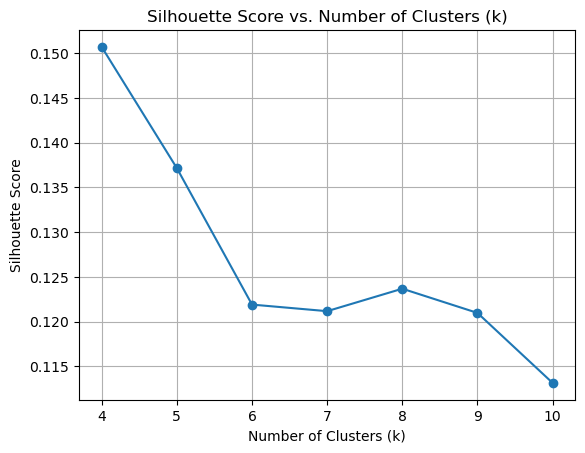

In [8]:
# Calculate Silhouette Score for different numbers of clusters
k_range = range(4, 11)  # Test k from 2 to 8
silhouette_scores = []

for k_test in k_range:
    kmeans_test = KMeans(n_clusters=k_test, n_init=50, random_state=0).fit(z500_latent)
    score = silhouette_score(z500_latent, kmeans_test.labels_)
    silhouette_scores.append(score)
    print(f'Silhouette Score for k={k_test}: {score}')

# Plot Silhouette Score
plt.figure()
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.savefig(filepath_ae + 'silhouette_score_vs_k.png')
plt.show()

**Re-order cluster labels according to associated precipitation**

In [9]:
pr_labeled_ae = cf.assign_labels(xarray_array=pr, labels=ae_clusters.labels_)
pr_by_label_ae = pr_labeled_ae.groupby('label').mean(dim=['time', 'latitude', 'longitude'])
cluster_order_ae = np.flip(np.argsort(pr_by_label_ae.values)).tolist()

dict_replace_ae = {i: cluster_order_ae.index(i) for i in range(k)}

def replace_ae(element):
    return dict_replace_ae.get(element, element)

vfunc_ae = np.vectorize(replace_ae)
relabeled_labels_ae = vfunc_ae(ae_clusters.labels_)

d_ae = {'Labels': 'AE', 'Value': relabeled_labels_ae}
df_ae = pd.DataFrame(data=d_ae)
df_ae.to_csv(filepath_ae + 'relabeled_labels.csv')

**Visualise cluster centers**

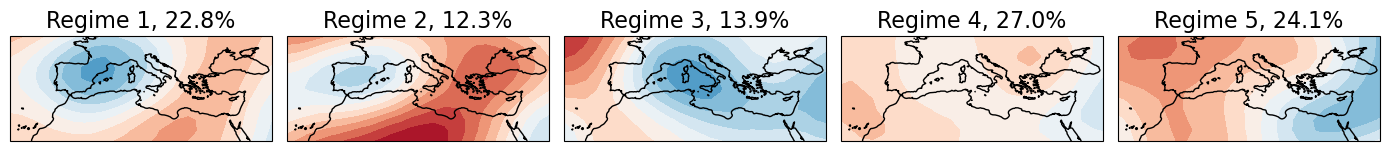

In [10]:
clusters_ae_vis = cf.visualise_contourplot(dataset_xarray=centroids_ae_xr,
                                           unit='[m]',
                                           cluster_results=ae_clusters,
                                           cluster_order=cluster_order_ae,
                                           regime_names=[f'Regime {i+1}' for i in range(k)],
                                           vmin=-1.7, vmax=1.7, steps=0.2, col_number=k,
                                           color_scheme='RdBu_r', borders=False,
                                           projection=ccrs.PlateCarree(central_longitude=0))

plt.savefig(filepath_ae + f'cluster_visualisation_{k}.png')

**Save cluster centers**

In [11]:
centroids_ae_flat = cf.reshape_data_for_clustering(centroids_ae_xr)
df_ae_centroids = pd.DataFrame(data=centroids_ae_flat)
df_ae_centroids.to_csv(filepath_ae + f'cluster_centers_{k}.csv')

**Calculate and plot precipitation odds ratios**

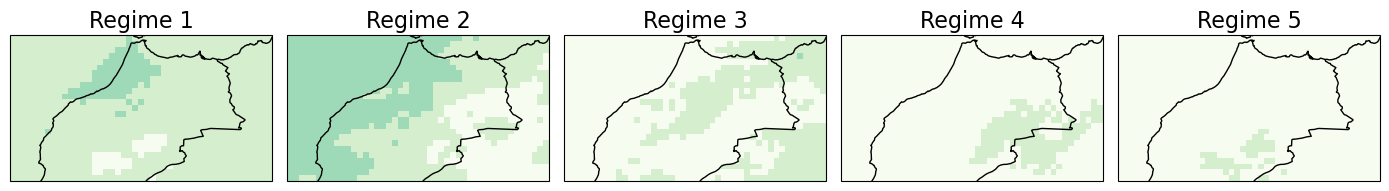

In [12]:
pr_qn95_ratio_ae = cf.calculate_conditional_probability_change(threshold_matrix=threshold_qn95,
                                                               kmeans=ae_clusters,
                                                               comparison='ratio', shift_value=0)

pr_qn95_vis_ae = cf.visualise_spatial_oddsratio(dataset_xarray=pr_qn95_ratio_ae, unit='',
                                                cluster_order=cluster_order_ae,
                                                color_scheme='GnBu', vmin=0, vmax=6, steps=7,
                                                title='Odds ratio of 95th percentile precipitation (AE)',
                                                regime_names=[f'Regime {i+1}' for i in range(k)],
                                                borders=True, projection=ccrs.PlateCarree(central_longitude=0),
                                                col_number=k)

plt.savefig(filepath_ae + f'oddsratio_95_{k}.png')

**t-SNE plots**

In [13]:
# Apply t-SNE to the AE latent space
X_embedded_z500_ae = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z500_latent)

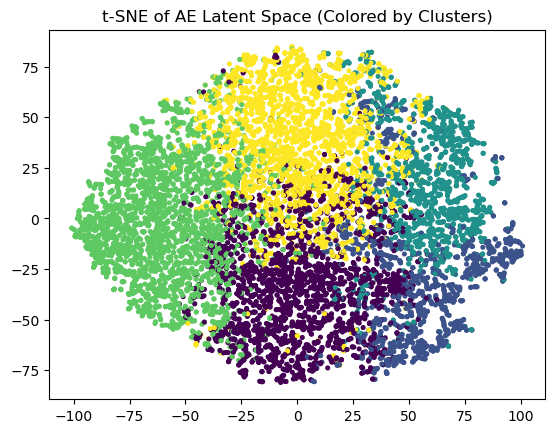

In [14]:
# Plot t-SNE colored by AE clusters
plt.figure()
scatter_ae_clusters = plt.scatter(X_embedded_z500_ae[:, 0], X_embedded_z500_ae[:, 1], c=relabeled_labels_ae, s=7, cmap='viridis')
plt.title('t-SNE of AE Latent Space (Colored by Clusters)')
#plt.legend(*scatter_ae_clusters.legend_elements(), title='Clusters')
plt.savefig(filepath_ae + 'tsne_clusters.png')
plt.show()

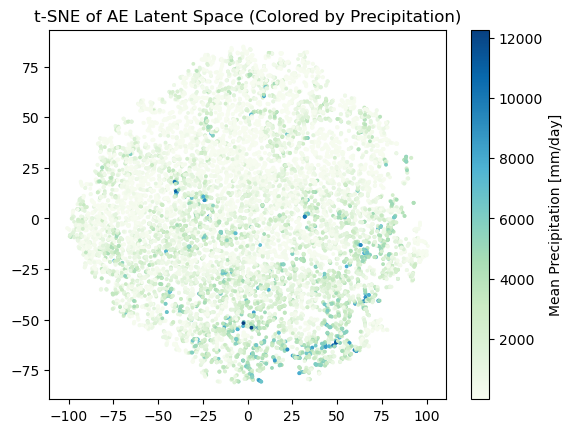

In [15]:
# Plot t-SNE colored by precipitation
plt.figure()
scatter_ae_pr = plt.scatter(X_embedded_z500_ae[:, 0], X_embedded_z500_ae[:, 1], c=pr_spatial.values, cmap='GnBu', s=3, alpha=1)
plt.title('t-SNE of AE Latent Space (Colored by Precipitation)')
plt.colorbar(label='Mean Precipitation [mm/day]')
plt.savefig(filepath_ae + 'tsne_precipitation.png')
plt.show()

**Reconstruction Loss**

In [16]:
# Reconstruct the full dataset using the trained AE
reconstructed_ae_reshaped = autoencoder.predict(z500_reshaped_ae)

# Calculate MSE
mse_ae = mean_squared_error(z500_reshaped_ae, reconstructed_ae_reshaped, multioutput='raw_values')
mse_ae_reshaped = mse_ae.reshape(ny, nx, order='F')

# Create xarray DataArray for MSE
mse_ae_reshaped_xr = xr.DataArray(mse_ae_reshaped, coords=z500[0, :, :].coords,
                                  dims=z500[0, :, :].dims, attrs=z500[0, :, :].attrs)

393/393 [==============================] - 0s 700us/step


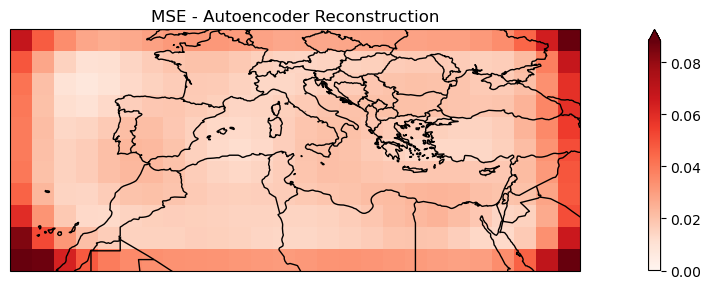

In [17]:
# Visualize MSE
fig_mse_ae = plt.figure(figsize=[14, 3])
ax_mse_ae = fig_mse_ae.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
mse_ae_reshaped_xr.plot(ax=ax_mse_ae, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=np.percentile(mse_ae, 99)) # Adjust vmax if needed
ax_mse_ae.coastlines()
ax_mse_ae.add_feature(cartopy.feature.BORDERS)
ax_mse_ae.set_title('MSE - Autoencoder Reconstruction')
plt.tight_layout()
plt.savefig(filepath_ae + 'reconstructed_mse.png')
plt.show()

**Box Plot of Reconstruction Error**

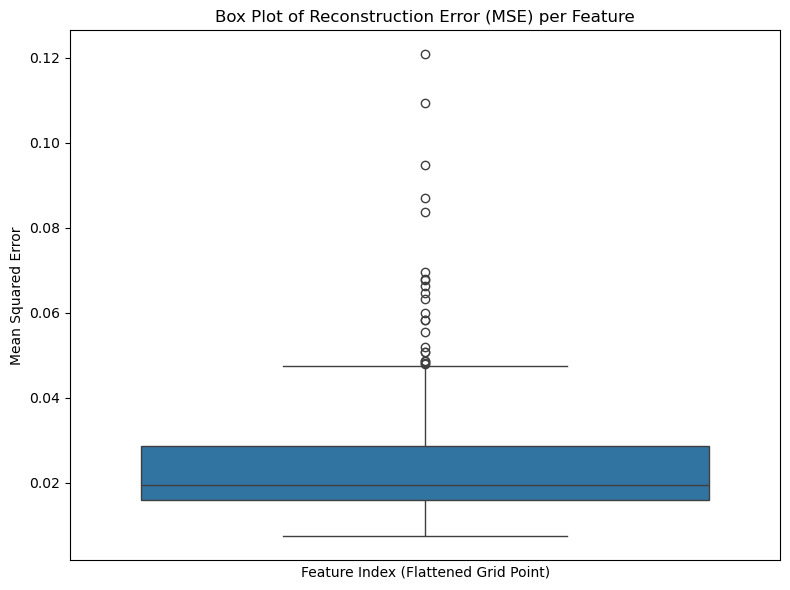

In [18]:
# Box plot of reconstruction error
plt.figure(figsize=(8, 6))
sns.boxplot(data=mse_ae)
plt.title('Box Plot of Reconstruction Error (MSE) per Feature')
plt.ylabel('Mean Squared Error')
plt.xlabel('Feature Index (Flattened Grid Point)')
# Optionally, hide x-axis labels if there are too many features
plt.xticks([]) # Hide x-axis labels
plt.tight_layout()
plt.savefig(filepath_ae + 'reconstruction_mse_boxplot.png')
plt.show()

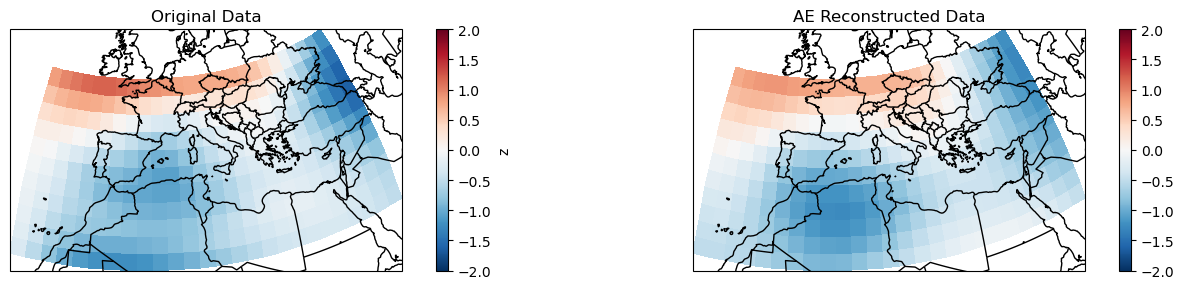

In [19]:
# Visualize an example reconstruction
reconstructed_ae = reconstructed_ae_reshaped.reshape(nt, ny, nx, order='F')
reconstructed_ae_xr = xr.DataArray(reconstructed_ae, coords=z500.coords, dims=z500.dims, attrs=z500.attrs)

fig_rec_ex = plt.figure(figsize=[14, 3])
count = 10 # Example time step

ax1_rec = fig_rec_ex.add_subplot(121, projection=ccrs.Orthographic(0, 45))
z500[count, :, :].plot(ax=ax1_rec, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
ax1_rec.coastlines()
ax1_rec.add_feature(cartopy.feature.BORDERS)
ax1_rec.set_title('Original Data')

ax2_rec = fig_rec_ex.add_subplot(122, projection=ccrs.Orthographic(0, 45))
reconstructed_ae_xr[count, :, :].plot(ax=ax2_rec, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
ax2_rec.coastlines()
ax2_rec.add_feature(cartopy.feature.BORDERS)
ax2_rec.set_title('AE Reconstructed Data')

plt.tight_layout()
plt.savefig(filepath_ae + f'reconstructed_example_{count}.png')
plt.show()